# Demonstration of how to use GPy to do model data comparison

I'll use this doc to demo the code, and find some initial results. Let's begin by loading the libraries we'll need.

In [5]:
import GPy
import sys
import os
sys.path.append(os.getenv("HOME") + "/Documents/Code/Emulation/GPyDifferentMetrics/")
from HaversineDist import Exponentialhaversine
import numpy as np
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib
import glob as glob
from cmocean import cm as cm
from Utilities import *


Now let's specify where the data and model runs are located, and load them.

In [3]:

GCM_dir = os.getenv("HOME")+'/Documents/Code/ModelDataComparison/DMC/Scripts/Model_data/CO2_anom/'
gcm_SSTs = glob.glob(GCM_dir+'t*.txt')

gcm_mask = np.genfromtxt(GCM_dir+'mask.txt', dtype='int')

obs_dir = os.getenv("HOME")+'/Documents/Code/ModelDataComparison/DMC/Scripts/Observation_data/P3+_SST_anom/'
file = 'lambda_10.txt'
observations = np.genfromtxt(obs_dir+file, skip_header=1)


We'll extract the observations into their coordinates (long and lat) which I'll refer to as X, the measurement (Y), and our estimate of the ratio of the variance of the measurement error at each point (NOTE: I was unsure whether the numbers in the data you gave me were supposed to standard deviations or variances - they look like std devs, so I've squared them). Note that all that matters is the relative size of these variances (their ratio). We need to try changing this to find its effect.

I've plotted the locations just as a check.

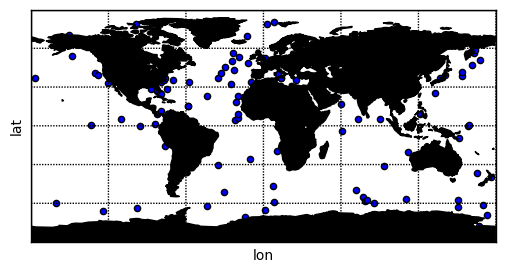

In [6]:
X_obs = observations[:,0:2]
y_obs = observations[:,2].reshape(-1,1)
var_ratios = observations[:,3][:,None]**2
map = plot_map(X_obs=X_obs)


## Fitting a Gaussian process model

Rather than use a GMRF to fit to the data, we will use a Gaussian process. This has the benefit of allowing us to use the extensive code base that has been developed over the past decade since GPs became prominent. They are also easier to understand, don't require as detailed knowledge to use, and are already widely used in the climate community as emulators. They do have some downsides which I'll discuss below.

We'll use the GPy software. This is widely seen to be the most complete and easiest to modify of the GP codes. It takes care of all the tricky numerical issues we face when using GPs. There is a large amount of training material online. It is in Python rather than R.

To begin with, *solely* for demonstration purposes, I'll use a standard GP (ignoring the fact we're on a sphere) just to demonstrate how simple the GPy code is. The basic steps we have to go through are
- specify a kernel/covariance function
- specify the model
- train the model

We achieve that with these three steps:

In [22]:
k = GPy.kern.Exponential(2, ARD=True)
m = GPy.models.GPRegression(X_obs, y_obs,k)
m.optimize_restarts(10)


Optimization restart 1/10, f = 199.8572178760952
Optimization restart 2/10, f = 199.85721789003586


 /home/sm1rw/GPy/GPy/kern/src/stationary.py:229: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/10, f = 199.88401625299838
Optimization restart 4/10, f = 199.8572178780155
Optimization restart 5/10, f = 199.85721787950712
Optimization restart 6/10, f = 199.8572178857363
Optimization restart 7/10, f = 199.85721787784212
Optimization restart 8/10, f = 199.85721802237254
Optimization restart 9/10, f = 199.85721787612016
Optimization restart 10/10, f = 199.85721787885578


Now all we need to do is check the hyper-parameter estimates, and plot the model predictions. To do this, we need to specify a grid where we want to predict. I've used a 2.5 degree grid below - we can use something finer later.

In [24]:
print(m)
print(m.Exponential.lengthscale)



latsplot = np.arange(-90.0,90.0, 2.5)
longsplot = np.arange(-180.0,180.0, 2.5)
longgridplot, latgridplot = np.meshgrid(longsplot, latsplot)
X_plot=np.column_stack((longgridplot.flatten(), latgridplot.flatten())) # specifies the prediction locations

mu,V = m.predict_noiseless(X_plot)


Name : GP regression
Objective : 199.8572178760952
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |          value  |  constraints  |  priors
  Exponential.variance     |  15.0309441245  |      +ve      |        
  Exponential.lengthscale  |           (2,)  |      +ve      |        
  Gaussian_noise.variance  |  1.47133680701  |      +ve      |        
  index  |  GP_regression.Exponential.lengthscale  |  constraints  |  priors
  [0]    |                           253.13279706  |      +ve      |        
  [1]    |                           101.71296071  |      +ve      |        


 /home/sm1rw/Documents/Code/ModelDataComparison/PythonCode/Utilities.py:19: FutureWarning:comparison to `None` will result in an elementwise object comparison in the future.


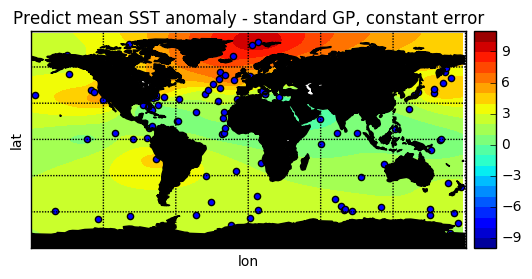

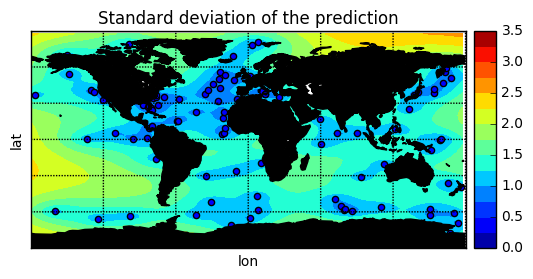

In [27]:

plt.figure(1)
map=plot_map(longgridplot, latgridplot, mu, X_obs)
plt.title('Predict mean SST anomaly - standard GP, constant error')

plt.figure(2)
map=plot_map(longgridplot, latgridplot, np.sqrt(V), X_obs, levels=np.arange(0,np.sqrt(V).max()+1,0.25))
plt.title('Standard deviation of the prediction')



There are a few comments to make about this. The first is that looking at the predicted mean (which is our best guess from the palaeo data of the SST anomaly), we can see that this is not realistic, as the patterns don't wrap around the globe, and there is too much variability at the north pole. This happens because we haven't told the GP that we are working on a sphere. We'll fix this in a moment.

The other comment is note that the prediction variance is small where we have data, and grows as we move away from the data. This is what we expect.

### GPs on spheres

Let's now tell the GP that we are modelling data on a sphere. To do this, we need to use the specially adapted covariance function that we've written. This is not part of the GPy distribution so we need to load it ourselves. I've called this Exponentialhaversine as it uses the Haversine distance to calculate the distance between two points on a sphere (NOTE: not on the globe), but is otherwise just a modification of the standard Exponential kernel.

The code we use to fit the model is exactly the same.

In [26]:

k2 = Exponentialhaversine(2, lengthscale=2000)
m2 = GPy.models.GPRegression(X_obs, y_obs,k2)
m2.optimize_restarts(10)


WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only


 /home/sm1rw/anaconda3/lib/python3.5/site-packages/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1


WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
Optimization restart 2/10, f = 230.29148806804022
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only



Name : GP regression
Objective : 200.4941680146405
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |          value  |  constraints  |  priors
  Exponential.variance     |  8.84356441352  |      +ve      |        
  Exponential.lengthscale  |  5403.17635525  |      +ve      |        
  Gaussian_noise.variance  |  1.09844546637  |      +ve      |        

Name : GP regression
Objective : 200.4941680146405
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |          value  |  constraints  |  priors
  Exponential.variance     |  8.84356441352  |      +ve      |        
  Exponential.lengthscale  |  5403.17635525  |      +ve      |        
  Gaussian_noise.variance  |  1.09844546637  |      +ve      |        
WARNING - ARD=False only


 /home/sm1rw/Documents/Code/ModelDataComparison/PythonCode/Utilities.py:19: FutureWarning:comparison to `None` will result in an elementwise object comparison in the future.


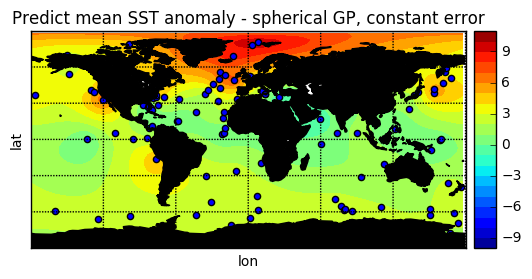

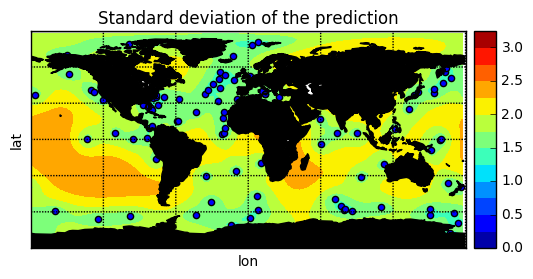

In [29]:
print(m2)
print(m2)
mu2,V2 = m2.predict(X_plot)

plt.figure(1)
map=plot_map(longgridplot, latgridplot, mu2, X_obs)
plt.title('Predict mean SST anomaly - spherical GP, constant error')

plt.figure(2)
map=plot_map(longgridplot, latgridplot, np.sqrt(V2), X_obs, levels=np.arange(0,np.sqrt(V2).max()+1,0.25))
plt.title('Standard deviation of the prediction')

This looks better. We now have a prediction that wraps around the globe (ie the same value at -180 and 180 longitude) and shrinks appropriately towards the poles. This plot looks very similar to those produces by Fran using Andrew's code (which is no surprise). I haven't managed to find the same colour map, and I've blacked out the continents, but the pattern over land looks very similar. 

A problem with this model is that it assumes the same measurement error at each point. We have written an extension to GPy that allows us to instead specify the measurement error.

### Heteroscedastic GPs

We've assumed that if

$$y = (y_1, \ldots, y_n$)$
is our data vector, then 
$$ y = f(x) + \epsilon$$
where $f(x)$ is the underlying SST pattern, and $\epsilon$ is the measurement error. Above we used a homoscedastic model and assumed $\mathbb{V}\mbox{ar}(\epsilon) = \sigma^2 I$, i.e. a constant times the identity matrix. Now we'll use a heteroscedastic model and assume

$$\mathbb{V}\mbox{ar}(y) = \tau D$$
where $D$ is a diagonal matrix specifying the ratios of the measurement variances, and $\tau$ is a free parameter which scales the measurement errors all by the same amount. Note that this is slightly different to what Fran did with the GMRF code where the numbers are just fixed. We can also do this (see below).

To use the heteroscedastic model, we have to again load our own code in, and then simply change the GPy model we use. Everything else remains the same.

In [32]:

from scaledheteroscedasticgaussian import ScaledHeteroscedasticGaussian
from gp_heteroscedastic_ratios import ScaledHeteroscedasticRegression


k3 = Exponentialhaversine(2, lengthscale=2000)
m3 = ScaledHeteroscedasticRegression(X=X_obs, Y=y_obs, kernel=k3, noise_mult=1., 
                                     known_variances=var_ratios)
m3.optimize_restarts(10)


WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
Optimization restart 1/10

 /home/sm1rw/anaconda3/lib/python3.5/site-packages/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1


WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
Optimization restart 2/10, f = 230.29148806663719
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only


 /home/sm1rw/GPy/GPy/kern/src/stationary.py:160: RuntimeWarning:overflow encountered in true_divide
 /home/sm1rw/GPy/GPy/kern/src/stationary.py:198: RuntimeWarning:invalid value encountered in multiply


WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
Optimization restart 6/10, f = 230.2914880705572
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
W


Name : gp
Objective : 202.73942289542626
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                          |          value  |  constraints  |  priors
  Exponential.variance         |  9.72822417707  |      +ve      |        
  Exponential.lengthscale      |  4778.83030186  |      +ve      |        
  Scaled_het_Gauss.noise_mult  |  7.99632407141  |      +ve      |        
WARNING - ARD=False only


 /home/sm1rw/Documents/Code/ModelDataComparison/PythonCode/Utilities.py:19: FutureWarning:comparison to `None` will result in an elementwise object comparison in the future.


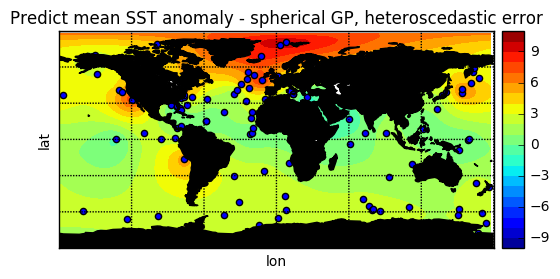

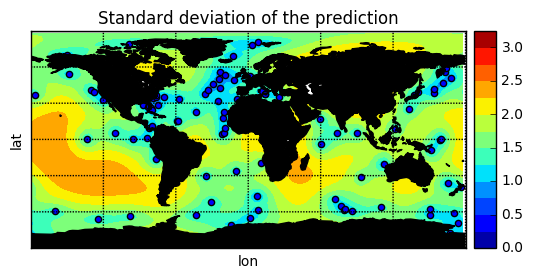

In [31]:
print(m3)

mu3,V3 = m3.predict_noiseless(X_plot)


plt.figure(3)
map=plot_map(longgridplot, latgridplot, mu3, X_obs)
plt.title('Predict mean SST anomaly - spherical GP, heteroscedastic error')

plt.figure(4)
map=plot_map(longgridplot, latgridplot, np.sqrt(V3), X_obs, levels=np.arange(0,np.sqrt(V3).max()+1,0.25))
plt.title('Standard deviation of the prediction')

If we look carefully, this has made some small difference to the predictions, but not much. If we try a different ratio, then we may or may not get different results. It looks though like the predictions are fairly robust to this choice - which is good!

In [33]:
file = 'lambda_100.txt'
observations = np.genfromtxt(obs_dir+file, skip_header=1)
var_ratios2 = observations[:,3][:,None]**2


k4 = Exponentialhaversine(2, lengthscale=2000)
m4 = ScaledHeteroscedasticRegression(X=X_obs, Y=y_obs, kernel=k4, noise_mult=1., 
                                     known_variances=var_ratios2)
m4.optimize_restarts(10)


WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only


 /home/sm1rw/anaconda3/lib/python3.5/site-packages/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1


WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
Optimization restart 2/10, f = 256.53568273468466
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only


 /home/sm1rw/GPy/GPy/kern/src/stationary.py:160: RuntimeWarning:overflow encountered in true_divide
 /home/sm1rw/GPy/GPy/kern/src/stationary.py:198: RuntimeWarning:invalid value encountered in multiply


WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
Optimization restart 7/10, f = 230.2914880666354
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
W


Name : gp
Objective : 202.73942289916496
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                          |            value  |  constraints  |  priors
  Exponential.variance         |    9.72846353257  |      +ve      |        
  Exponential.lengthscale      |     4779.0104067  |      +ve      |        
  Scaled_het_Gauss.noise_mult  |  0.0799643664688  |      +ve      |        
WARNING - ARD=False only


 /home/sm1rw/Documents/Code/ModelDataComparison/PythonCode/Utilities.py:19: FutureWarning:comparison to `None` will result in an elementwise object comparison in the future.


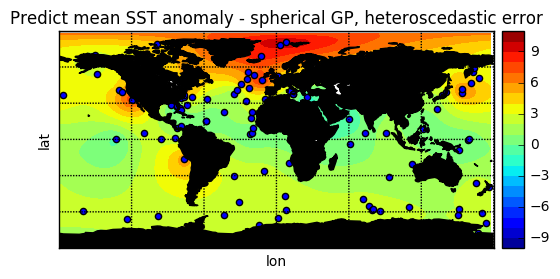

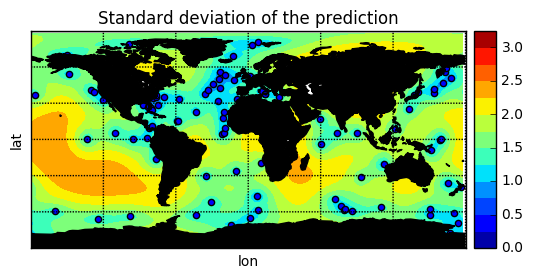

In [34]:
print(m4)

mu4,V4 = m4.predict_noiseless(X_plot)


plt.figure(3)
map=plot_map(longgridplot, latgridplot, mu4, X_obs)
plt.title('Predict mean SST anomaly - spherical GP, heteroscedastic error')

plt.figure(4)
map=plot_map(longgridplot, latgridplot, np.sqrt(V4), X_obs, levels=np.arange(0,np.sqrt(V4).max()+1,0.25))
plt.title('Standard deviation of the prediction')

A small caveat about these results are that I've had to use an isotropic kernel here (that is why I've left in the warning about not using ARD kernel's that prints out above). That means that the spatial dependence is the same in all directions. I can probably fix this, but its a bit of work so haven't done so yet. I suspect Andrew's code allowed us to use non-isotropic covariance structure (is that right Fran?)

The run time for each of the commands above is significantly less than a second. This I think would be much faster than the GMRF approach. Of course, if we have 1000s of data points, then this approach will be slower, and if we had 10,000s of data points then we'd have to use some approximate methods or revert to the GMRF approach.

Note the advantage of using GPy here. I can use all the built in functionality. If we want to fix the observation error, add a prior, use a sparse approximation, do MCMC etc, we can use the existing GPy code with no extra work. That is potentially very valuable.

For example, let's suppose we want to fix the measurement error to be 0.1 - this is easy using the built in functionality. This reduces the measurement error model to be exactly the same as Fran was using with Andrew's GMRF code.

In [40]:
k4 = Exponentialhaversine(2, lengthscale=2000)
m4 = ScaledHeteroscedasticRegression(X=X_obs, Y=y_obs, kernel=k4, noise_mult=1., 
                                     known_variances=var_ratios2)
m4.Scaled_het_Gauss.noise_mult.fix(0.1)

m4.optimize()
print(m4)



WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only
WARNING - ARD=False only

Name : gp
Objective : 202.93321470935862
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Param

 /home/sm1rw/anaconda3/lib/python3.5/site-packages/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1


## Likelihood calculations

Let's now evaluate the 8 GCM simulations we have available. To do this, we need to predict the GCM output at every grid cell, and then evalaute the probability of seeing this value under our GP model fitted to the observational data. Because the GCM data is on a fine grid (with 27000 values over ocean), this is difficult to work with (we can do so - but it takes a while). So for the purposes of debugging, I've thinned the grid to only predict every second value. This won't make any difference as the data are course (and we can fix it later), but it does speed up the prediction by a factor of 16.

Let's first demonstrate this calculation on a single GCM run, and then below we'll use a more efficient approach to do all 8 values at once. Let's first load the data:

In [43]:
from scipy.stats import multivariate_normal
file_name = gcm_SSTs[0]
print(file_name)

gcm1 = np.genfromtxt(file_name)

/home/sm1rw/Documents/Code/ModelDataComparison/DMC/Scripts/Model_data/CO2_anom/tczyj.txt


Now we'll thin the GCM grid and data, throw away values over land (as there is no need to predict here - its just unnecessary costs), predict using the trained GP from above. This takes about a minute on my machine (so would take about 16 minutes to do with the unthinned grid, assuming I don't run out of memory).

In [44]:
X_pred, gcm_grid = ThinGrid(gcm1, gcm_mask, thinby=2)
mu, Cov = m3.predict_noiseless(X_pred, full_cov=True)

print(multivariate_normal.logpdf(gcm_grid.flatten(), mu.flatten(), Cov))


WARNING - ARD=False only
WARNING - ARD=False only
-4412.126893


We can make this more efficient by doing all the likelihood calculations at once. That way, we only need to invert the variance matrix once. Let's load all of the GCM runs.

In [64]:
gcm_runs = np.zeros((8,27186))

count=0

for file_name in gcm_SSTs:
    print(file_name)
    file_nm = file_name.split(GCM_dir)[-1]

    # Read in GCM output.
    gcm_runs[count,:] = np.genfromtxt(file_name)
    count +=1
#    X_pred, gcm_grid = ThinGrid(gcm1, gcm_mask, thinby=5)
    


/home/sm1rw/Documents/Code/ModelDataComparison/DMC/Scripts/Model_data/CO2_anom/tczyj.txt
/home/sm1rw/Documents/Code/ModelDataComparison/DMC/Scripts/Model_data/CO2_anom/tczyi.txt
/home/sm1rw/Documents/Code/ModelDataComparison/DMC/Scripts/Model_data/CO2_anom/tdgtk.txt
/home/sm1rw/Documents/Code/ModelDataComparison/DMC/Scripts/Model_data/CO2_anom/tczyk.txt
/home/sm1rw/Documents/Code/ModelDataComparison/DMC/Scripts/Model_data/CO2_anom/tdgtj.txt
/home/sm1rw/Documents/Code/ModelDataComparison/DMC/Scripts/Model_data/CO2_anom/tdgth.txt
/home/sm1rw/Documents/Code/ModelDataComparison/DMC/Scripts/Model_data/CO2_anom/tdgti.txt
/home/sm1rw/Documents/Code/ModelDataComparison/DMC/Scripts/Model_data/CO2_anom/tdgtg.txt


Now let's thin them all.

In [105]:
thinby=5
tmp1, tmp2 = ThinGrid(gcm_runs[0,:], gcm_mask, thinby=thinby) # just to get size
gcm_thin = np.zeros((8, tmp2.size))

for count in range(8):
    X_pred, out = ThinGrid(gcm_runs[count,:], gcm_mask, thinby=thinby)
    gcm_thin[count,:] = out.flatten()
    


In [106]:
 
mu, Cov = m3.predict_noiseless(X_pred, full_cov=True)

loglikes = multivariate_normal.logpdf(gcm_thin, mu.flatten(), Cov)

print(loglikes)

WARNING - ARD=False only
WARNING - ARD=False only
[-1337.00355768 -1350.04901104 -1370.06533309 -1347.33161981 -1341.11914014
 -1348.74843002 -1784.24393279 -1328.66019034]


This tells us that the 8th model prediction is the best here,followed by the first. These were 

In [107]:
print(gcm_SSTs[7].split(GCM_dir)[-1])
print(gcm_SSTs[0].split(GCM_dir)[-1])
round(loglikes[7])

tdgtg.txt
tczyj.txt


-1329.0

 /home/sm1rw/Documents/Code/ModelDataComparison/PythonCode/Utilities.py:19: FutureWarning:comparison to `None` will result in an elementwise object comparison in the future.


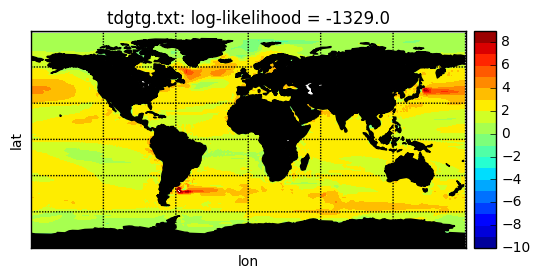

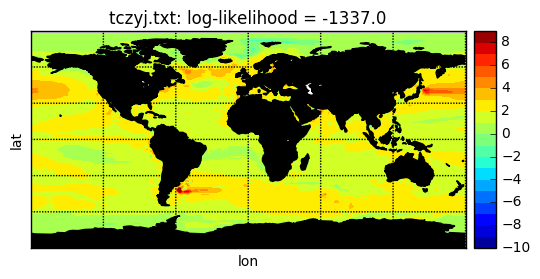

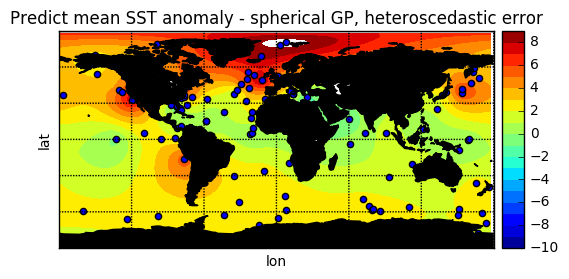

In [113]:
map = plot_gcm(gcm_runs[7,:], gcm_mask)
plt.title(gcm_SSTs[7].split(GCM_dir)[-1]+': log-likelihood = ' + str(round(loglikes[7])))

plt.figure()
map = plot_gcm(gcm_runs[0,:], gcm_mask)
plt.title(gcm_SSTs[0].split(GCM_dir)[-1]+': log-likelihood = ' + str(round(loglikes[0])))


# and for comparison the GP fit
plt.figure(3)
map=plot_map(longgridplot, latgridplot, mu3, X_obs, levels=np.arange(-10,10,1))
plt.title('Predict mean SST anomaly - spherical GP, heteroscedastic error')


Its not necessarily easy to judge by eye (particularly because of the stretching that comes from the daft map projection), but these two simulations do perhaps look plausibly closer to the GP prediction from the data than the others

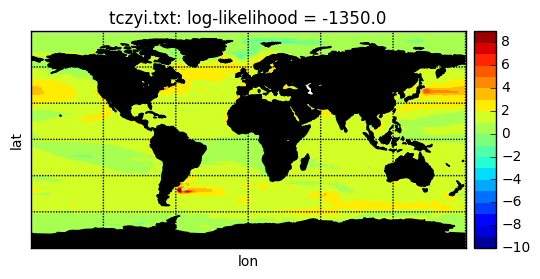

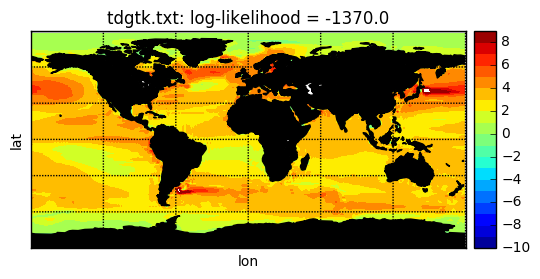

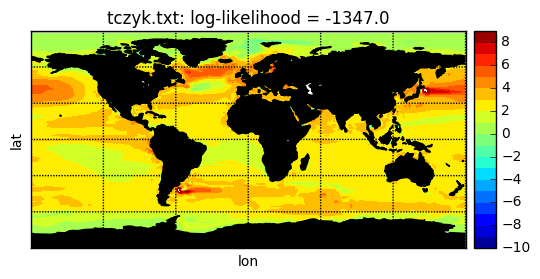

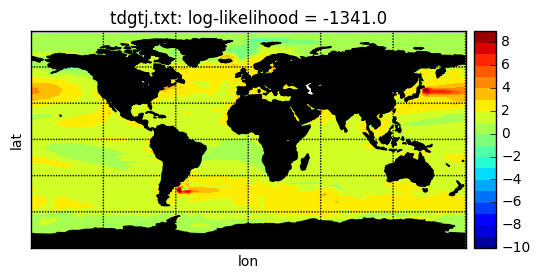

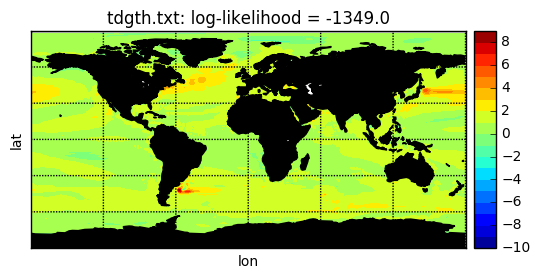

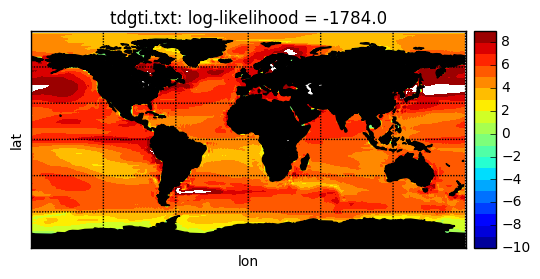

In [109]:
map = plot_gcm(gcm_runs[1,:], gcm_mask)
plt.title(gcm_SSTs[1].split(GCM_dir)[-1]+': log-likelihood = ' + str(round(loglikes[1])))

plt.figure()
map = plot_gcm(gcm_runs[2,:], gcm_mask)
plt.title(gcm_SSTs[2].split(GCM_dir)[-1]+': log-likelihood = ' + str(round(loglikes[2])))

plt.figure()
map = plot_gcm(gcm_runs[3,:], gcm_mask)
plt.title(gcm_SSTs[3].split(GCM_dir)[-1]+': log-likelihood = ' + str(round(loglikes[3])))

plt.figure()
map = plot_gcm(gcm_runs[4,:], gcm_mask)
plt.title(gcm_SSTs[4].split(GCM_dir)[-1]+': log-likelihood = ' + str(round(loglikes[4])))

plt.figure()
map = plot_gcm(gcm_runs[5,:], gcm_mask)
plt.title(gcm_SSTs[5].split(GCM_dir)[-1]+': log-likelihood = ' + str(round(loglikes[5])))

plt.figure()
map = plot_gcm(gcm_runs[6,:], gcm_mask)
plt.title(gcm_SSTs[6].split(GCM_dir)[-1]+': log-likelihood = ' + str(round(loglikes[6])))





Note that the uncertainty in our predictions (i.e. the how the matrix Cov is defined), is that it is the uncertainty in the underlying function. There is no measurement error component here. We may want to think about whether we need to add more noise in or not.

We can also compute the log-likelihood for other values. The best possible value achievable is using the GP mean surface. 
  

In [110]:
multivariate_normal.logpdf(mu.flatten(), mu.flatten(), Cov)

-1023.959866732162

We can get an idea of the variability in this value by generating simulations from the GP posterior distribution, and then evaluating the log-likelihood of these.

In [111]:
samples = multivariate_normal.rvs(mu.flatten(), Cov, size=20)
multivariate_normal.logpdf(samples, mu.flatten(), Cov)

array([-1549.29818206, -1577.77391851, -1592.52781051, -1579.95804706,
       -1604.64533616, -1604.03833373, -1589.30613957, -1552.10398893,
       -1581.41486306, -1558.30359082, -1565.89387683, -1551.38461177,
       -1592.58068211, -1554.60949442, -1583.25686872, -1582.97167801,
       -1613.9368869 , -1562.61666469, -1547.89827689, -1562.32218802])

Why are these values so small compared to those we've generated? I suspect its to do with the covariance function we've chosen, but I should look into this a little more.


ValueError: total size of new array must be unchanged

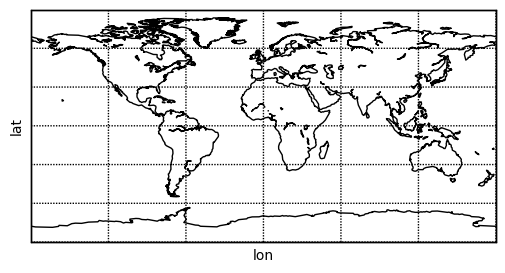

In [115]:
plt.figure(3)
map=plot_map(longgridplot, latgridplot, samples[0,:])#, levels=np.arange(-10,10,1))
plt.title('Predict mean SST anomaly - spherical GP, heteroscedastic error')


In [116]:
longgridplot.shape


(72, 144)

In [117]:
samples.shape

(20, 1092)

In [118]:
72*144

10368